In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcard/creditcard.csv


# **Introduction**

In this data science project, we aim to develop an effective fraud detection system
using machine learning techniques. By analyzing historical credit card transaction data,
we can identify patterns and anomalies associated with fraudulent behavior. Our goal is to 
build a robust model that can accurately distinguish between legitimate transactions and fraudulent ones.

# **Imports**

In [10]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
import os

# **Data Importing**


In [11]:

# Specify the path to the dataset folder
data_path = '/kaggle/input/creditcard'

# Load the credit card dataset
df = pd.read_csv(os.path.join(data_path, 'creditcard.csv'))

# Verify that the data has been loaded
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [12]:
print(df.columns)


Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [15]:
df.shape


(284807, 31)

In [16]:
df = df.sample(frac = 0.2, random_state = 1)
print(df.shape)

(56961, 31)


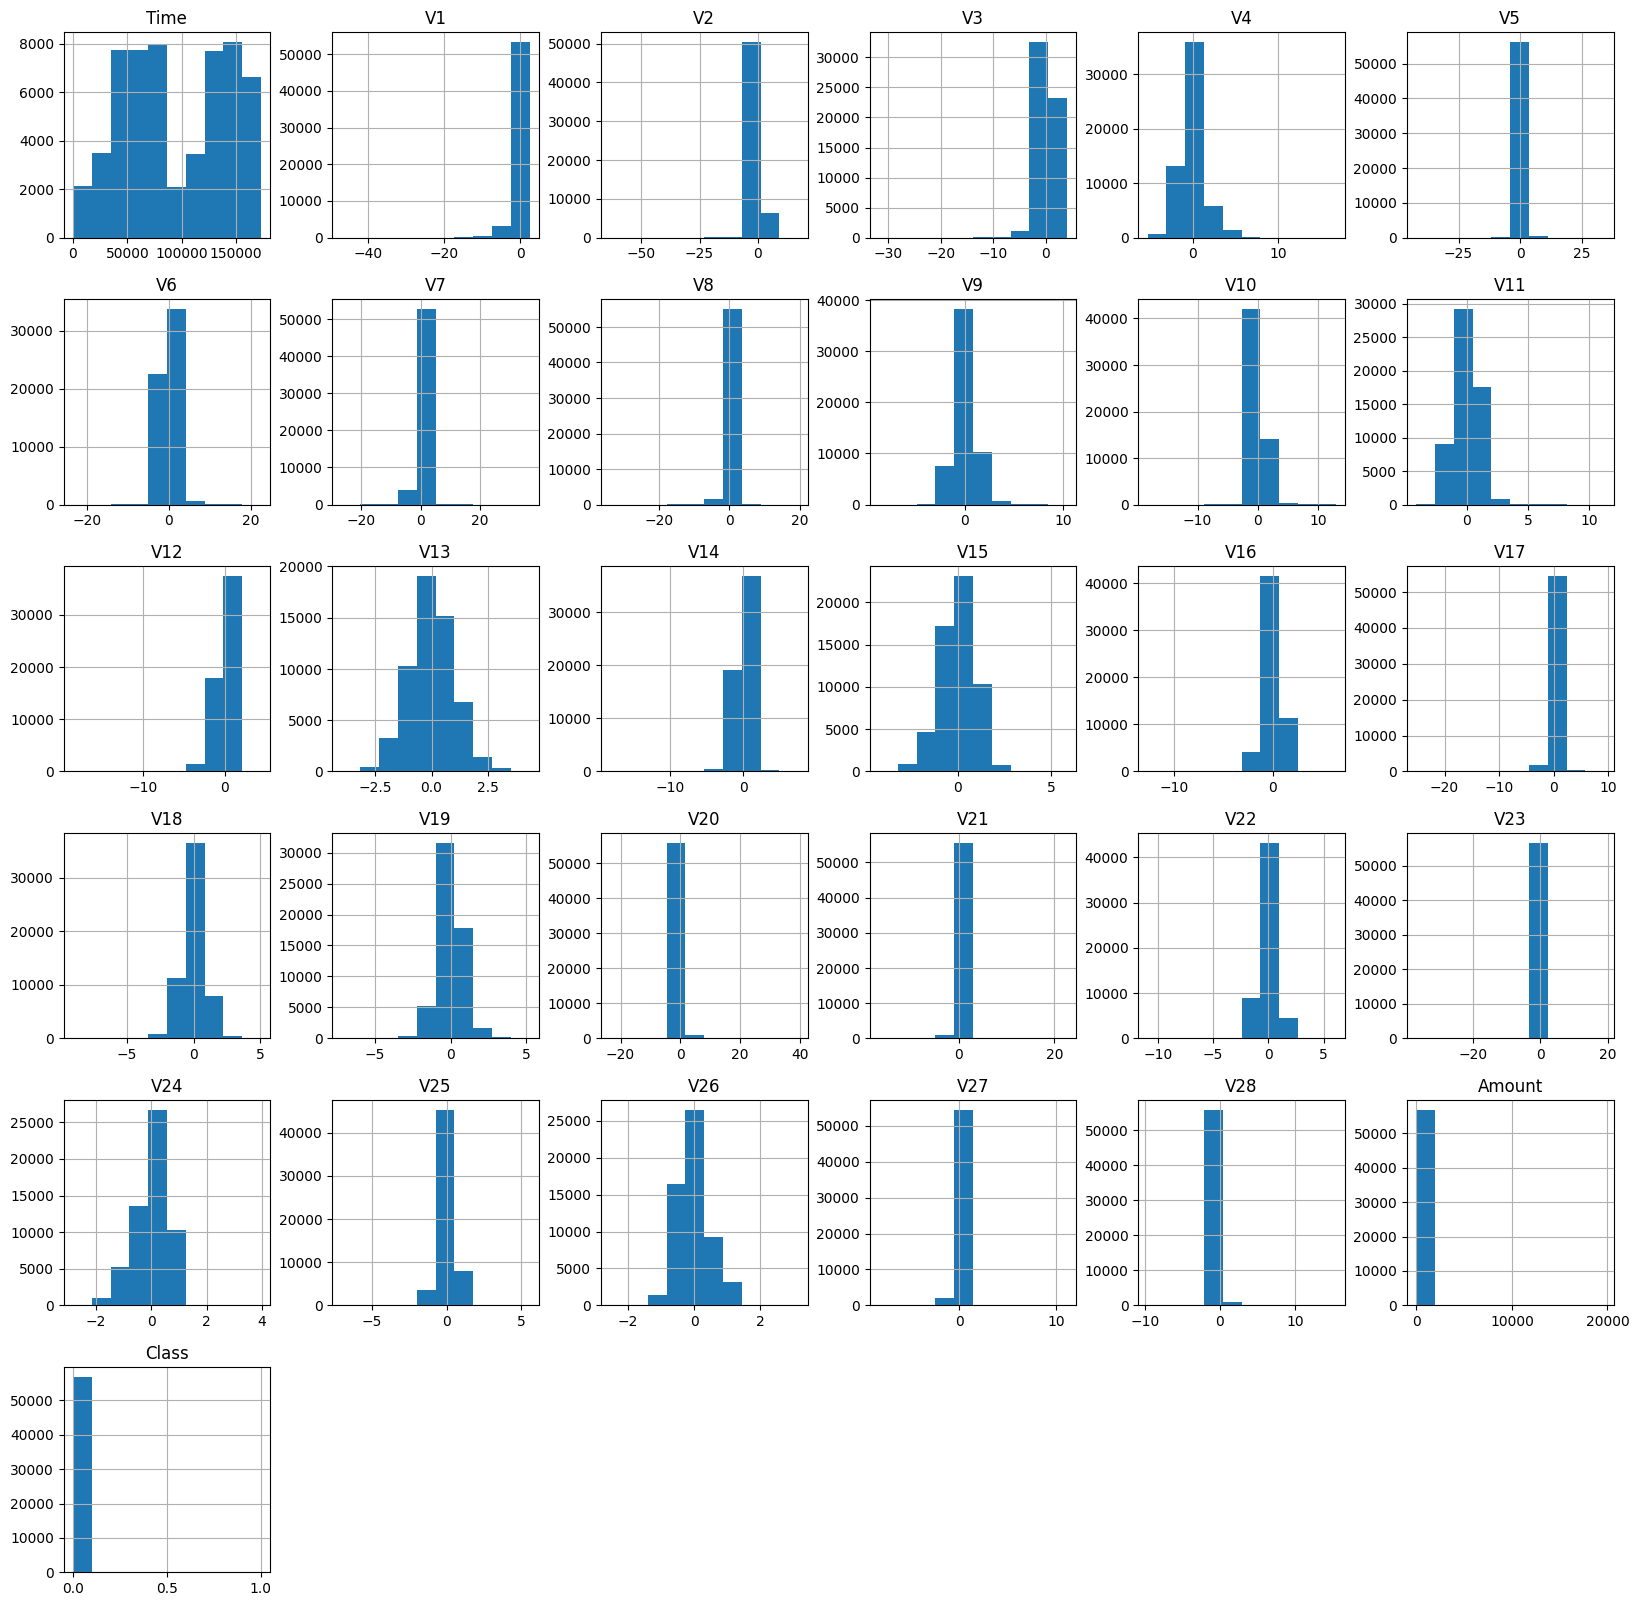

In [17]:
# plot the histogram of each parameter
df.hist(figsize = (20, 20))
plt.show()

In [18]:
# determine the number of fraud cases
fraud = df[df['Class'] == 1]
valid = df[df['Class'] == 0]

outlier_fraction = len(fraud) / float(len(valid))
print(outlier_fraction)

print('Fraud Cases: {}'.format(len(fraud)))
print('Valid Cases: {}'.format(len(valid)))

0.0015296972254457222
Fraud Cases: 87
Valid Cases: 56874


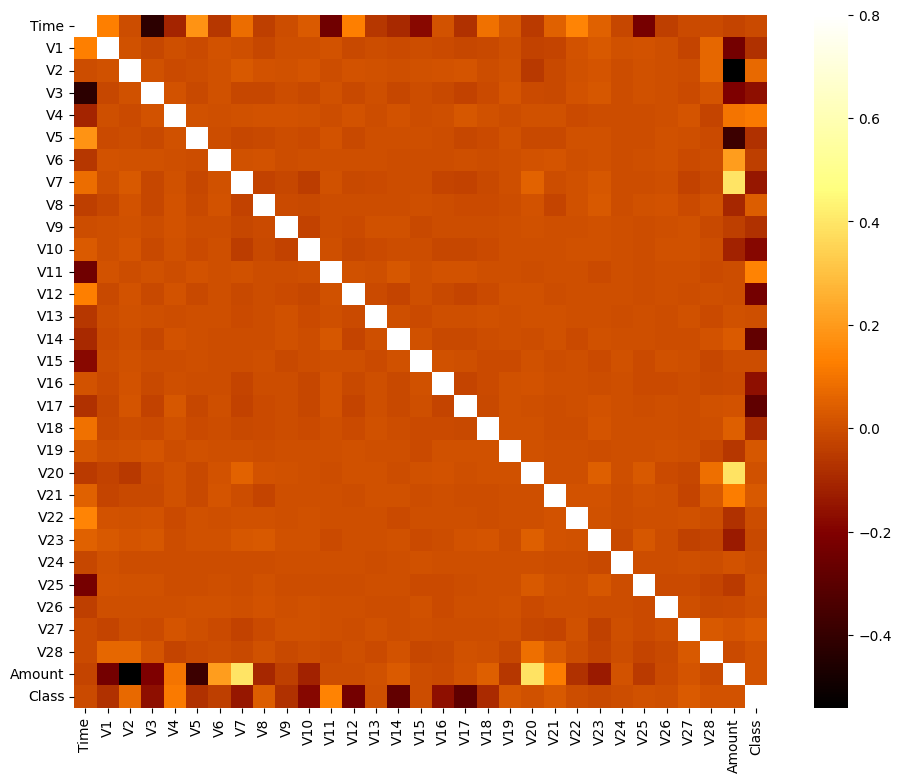

In [23]:
# Assuming 'df' is the DataFrame containing the data
# Calculate the correlation matrix
corrmat = df.corr()

# Set up the matplotlib figure
fig = plt.figure(figsize=(12, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrmat, vmax=.8, square=True, cmap='afmhot')  # Changed color palette to 'coolwarm'
plt.show()


# Organizing the Data
# 

In [25]:
# Get the columns from the DataFrame
columns = df.columns.tolist()

# Filter the columns to remove the data we do not want
columns = [c for c in columns if c not in ['Class']]

# Store the variable we will be predicting on, which is 'Class'
target = 'Class'

# X includes everything except our class column
X = df[columns]
# Y includes all the class labels for each sample (this is also one-dimensional)
Y = df[target]

# Print the shapes of X and Y
print(X.shape)
print(Y.shape)


(56961, 30)
(56961,)


# Applying Algorithms
# 

In [27]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [29]:
state = 1

# Define the outlier detection methods
classifiers = {
    # Contamination is the proportion of outliers we expect
    'Isolation Forest': IsolationForest(max_samples=len(X),
                                       contamination=outlier_fraction,
                                       random_state=state),
    # Number of neighbors to consider; adjust based on the expected percentage of outliers
    'Local Outlier Factor': LocalOutlierFactor(
        n_neighbors=20,
        contamination=outlier_fraction)
}


# Fit the Model
# 

In [30]:
n_outliers = len(fraud)

for i, (clf_name, clf) in enumerate(classifiers.items()):
    # Fit the data and tag outliers
    if clf_name == 'Local Outlier Factor':
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
        
    # Reshape the prediction values to 0 for valid and 1 for fraud
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1

    # Calculate the number of errors
    n_errors = (y_pred != Y).sum()
    
    # Classification matrix
    print('{}: {}'.format(clf_name, n_errors))
    print(accuracy_score(Y, y_pred))
    print(classification_report(Y, y_pred))


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Isolation Forest: 127
0.997770404311722
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56874
           1       0.27      0.28      0.27        87

    accuracy                           1.00     56961
   macro avg       0.64      0.64      0.64     56961
weighted avg       1.00      1.00      1.00     56961

Local Outlier Factor: 173
0.9969628342199048
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56874
           1       0.01      0.01      0.01        87

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961



In [ ]:
Fraud Detection Evaluation Summary

Precision: Precision tells us the percentage of correctly labeled fraudulent cases. 
It accounts for false positives (legitimate transactions flagged as fraud). Low precision could lead to annoying client inquiries.
Recall: Recall accounts for false negatives (fraudulent transactions missed). It’s essential to strike a balance between precision and recall.
    
Goal: Our aim is to improve these percentages.
Isolation Forest Method (Random Forest based):

Produced better results.
F1-score: Approximately 26% (or 30%) of the time, we successfully detect fraudulent transactions.